In [5]:
from melee_dataset import MeleeDataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.distributions import Categorical
from torch.distributions import Bernoulli,Normal
import matplotlib.pyplot as plt
from PolicyNet import PolicyNet
import torch.nn.functional as F
from Agents.BCAgent import BCAgent

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# train_dataset = MeleeDataset(data_path="data/train_mini_515")
train_dataset = MeleeDataset(data_path="data/train_mini_40")
# train_dataset = MeleeDataset(data_path="data/train_mini_5_fox_falco_dl")
# train_dataset = MeleeDataset(data_path="data/train_mini_10_with_hitstun")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# val_dataset = MeleeDataset(data_path="data/val_mini_1")
val_dataset = MeleeDataset(data_path="data/val_mini_10")
# val_dataset = MeleeDataset(data_path="data/val_mini_2_with_hitstun")
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)


In [7]:
print(f"obs_dim: {train_dataset[0][0].shape}")
print(f"act_dim: {train_dataset[0][1].shape}")

obs_dim: torch.Size([70])
act_dim: torch.Size([17])


In [8]:

from Agents.BCAgent import BCAgent
from Agents.IQLAgent import IQLAgent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
obs_dim = train_dataset[0][0].shape[0]
act_dim = train_dataset[0][1].shape[0]
# agent = BCAgent(obs_dim, act_dim, device)
agent = IQLAgent(obs_dim, act_dim, device, param_update_freq=50)

# set the seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

losses = []
val_losses = []
batch_cnt = 0
for epoch in range(10):
    total_loss = 0.0
    for i, (states, actions, next_states) in tqdm(enumerate(train_loader)):
        states = states.to(device)       # [B, obs_dim]
        actions = actions.to(device)     # [B] integers in [0…act_dim-1]
        next_states = next_states.to(device)
        # for i in range(1000):
        loss = agent.train(states, actions, next_states)
        vl, ql, pl = loss
        # print(loss)
        losses.append(loss)
        # break
        total_loss += pl * states.shape[0]
        batch_cnt += 1

        # if batch_cnt % 100 == 0:
        #     val_loss = 0.0  
        #     for i, (states, actions, next_states) in tqdm(enumerate(val_loader)):
        #         states = states.to(device)       # [B, obs_dim]
        #         actions = actions.to(device)     # [B] integers in [0…act_dim-1]
        #         next_states = next_states.to(device)

        #         val_loss += agent.validate(states, actions)
        #     avg_val_loss = val_loss / len(val_dataset)
        #     val_losses.append(avg_val_loss)
        #     print(f"Epoch {epoch+1} — Val Loss: {avg_val_loss:.4f}")
    # break

    avg_loss = total_loss / len(train_dataset)
    # losses.append(avg_loss)
    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f}")




Using device: cuda


3303it [01:16, 43.22it/s] 


Epoch 1 — Loss: 6.7562


3303it [00:20, 163.02it/s]


Epoch 2 — Loss: -9.7232


3303it [00:20, 162.83it/s]


Epoch 3 — Loss: -10.8820


3303it [00:20, 159.58it/s]


Epoch 4 — Loss: -11.2724


3303it [00:21, 155.81it/s]


Epoch 5 — Loss: -11.8849


3303it [00:21, 154.01it/s]


Epoch 6 — Loss: -13.1007


3303it [00:20, 159.25it/s]


Epoch 7 — Loss: -14.1708


3303it [00:21, 152.90it/s]


Epoch 8 — Loss: -15.0811


3303it [00:21, 154.71it/s]


Epoch 9 — Loss: -15.5228


3303it [00:20, 157.96it/s]

Epoch 10 — Loss: -15.3875


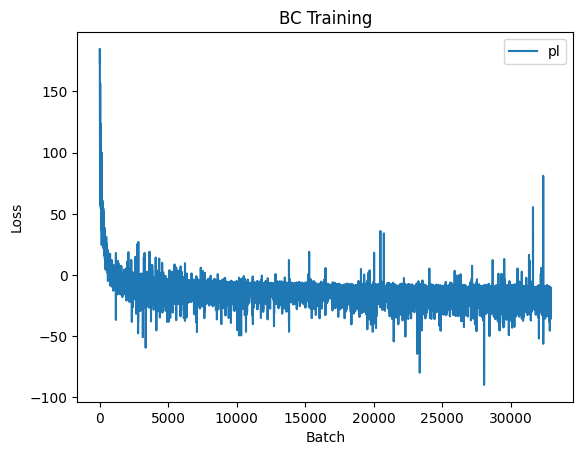

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.title("BC Training")
plt.xlabel("Batch")
plt.ylabel("Loss")
# plt.xticks(np.arange(0, 6, 1))
# plt.yscale("log")
# plt.plot([losses[i][0] for i in range(len(losses))], label="vl")
# plt.plot([losses[i][1] for i in range(len(losses))], label="ql")
plt.plot([losses[i][2] for i in range(100,len(losses))], label="pl")
# plt.plot(losses, label="train loss")
# plt.plot([100 * i for i in range(1, len(val_losses)+1)], val_losses, label="val loss")
plt.legend()
plt.show()



In [15]:
# Save the trained model
torch.save(agent.policy.state_dict(), "iql_40.pth")
# torch.save(agent.policy_net.state_dict(), "fox_5.pth")
# print("Model saved to trained_policy.pth")
